<a href="https://www.kaggle.com/code/alaaibrahim222/unet-semantic-segmentation?scriptVersionId=156368503" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/carvana-segmentation-challenge-done-with-u-net/__results__.html
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/__resultx__.html
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/my_checkpoint.pth.tar
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/__notebook__.ipynb
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/__output__.json
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/custom.css
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/pred_70.png
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/94.png
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/48.png
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/pred_10.png
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/pred_29.png
/kaggle/input/carvana-segmentation-challenge-done-with-u-net/saved_images/61.png
/kaggle/input/carvana-segmentat

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [3]:
import zipfile
# 'test.zip'
dirs = ['train.zip','train_masks.zip']
for x in dirs:
    with zipfile.ZipFile("../input/carvana-image-masking-challenge/"+ x,'r') as z:
        z.extractall(".")

In [4]:
!ls 

__notebook__.ipynb  train  train_masks


In [5]:
LEARNING_RATE = 1e-4
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 4
NUM_WORKERS = 4
IMAGE_HEIGHT = 572
IMAGE_WIDTH = 572
PIN_MEMORY = True
DATAPATH = "../input/carvana-image-masking-challenge/"
TRAIN_IMG_DIR = './train'
TRAIN_MASK_DIR = './train_masks'

In [6]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
    return conv.to(DEVICE)

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )
    def forward(self, image):
        # expected size
        # encoder (Normal convolutions decrease the size)
        x1 = self.down_conv_1(image)
        # print("x1 "+str(x1.shape))
        x2 = self.max_pool_2x2(x1)
        # print("x2 "+str(x2.shape))
        x3 = self.down_conv_2(x2)
        # print("x3 "+str(x3.shape))
        x4 = self.max_pool_2x2(x3)
        # print("x4 "+str(x4.shape))
        x5 = self.down_conv_3(x4)
        # print("x5 "+str(x5.shape))
        x6 = self.max_pool_2x2(x5)
        # print("x6 "+str(x6.shape))
        x7 = self.down_conv_4(x6)
        # print("x7 "+str(x7.shape))
        x8 = self.max_pool_2x2(x7)
        # print("x8 "+str(x8.shape))
        x9 = self.down_conv_5(x8)
        # print("x9 "+str(x9.shape))
        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        # print(x.shape)
        return x.to(DEVICE)

In [7]:
class CarvanaDataset(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index].replace(".jpg","_mask.gif"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image,mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
            
        return {"image":image,"mask":mask}

In [8]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

(1280, 1918, 3)


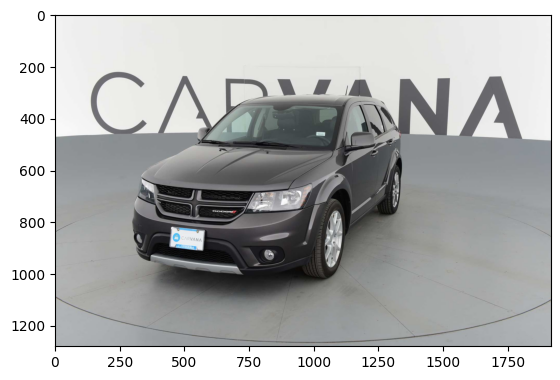

In [9]:
img = np.array(Image.open(TRAIN_IMG_DIR+"/"+images[0]).convert("RGB"))
plt.imshow(img,cmap="gray")
print(img.shape)

(1280, 1918)


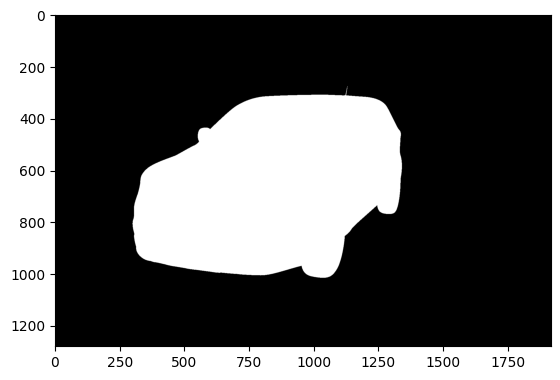

In [10]:
msk = np.array(Image.open(TRAIN_MASK_DIR+"/"+images[0].replace(".jpg","_mask.gif")).convert("L"))
plt.imshow(msk,cmap="gray")
print(msk.shape)

In [11]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs =outputs.squeeze(1)
        loss = criterion(outputs,mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs =outputs.squeeze(1)
            loss = criterion(outputs,mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss
        

In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Rotate(limit=35,p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [14]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [15]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = CarvanaDataset(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = CarvanaDataset(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

Epoch 1 of 4
-------------Training---------------


1018it [26:29,  1.56s/it]



--------Validating---------



255it [02:58,  1.43it/s]


Train Loss: 0.1194
Val Loss: 0.0541
Epoch 2 of 4
-------------Training---------------


1018it [26:26,  1.56s/it]



--------Validating---------



255it [02:57,  1.44it/s]


Train Loss: 0.0361
Val Loss: 0.0481
Epoch 3 of 4
-------------Training---------------


1018it [26:25,  1.56s/it]



--------Validating---------



255it [02:58,  1.43it/s]


Train Loss: 0.0201
Val Loss: 0.0154
Epoch 4 of 4
-------------Training---------------


1018it [26:26,  1.56s/it]



--------Validating---------



255it [02:57,  1.44it/s]


Train Loss: 0.0143
Val Loss: 0.0129


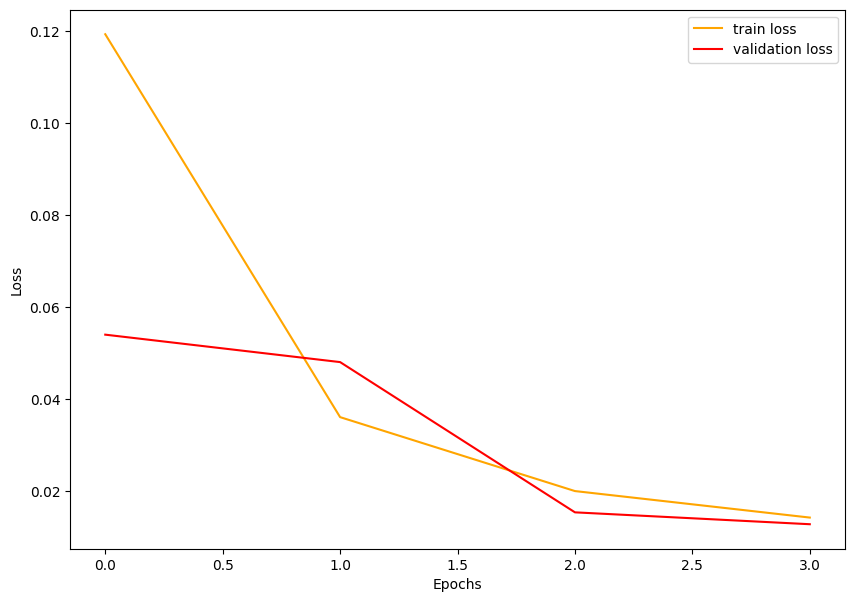


---------DONE TRAINING----------



In [16]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")
    

torch.Size([572, 572])


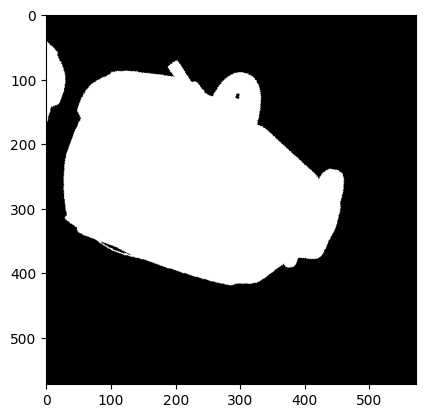

In [17]:
data = train_data.__getitem__(100)
plt.imshow(data['mask'],cmap="gray")
print(train_data.__getitem__(0)['mask'].shape)

torch.Size([3, 572, 572])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([572, 572])


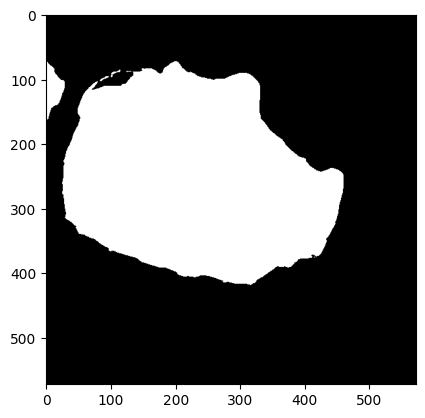

In [18]:
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
# model = UNet()
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

https://medium.com/mlearning-ai/semantic-segmentation-with-pytorch-u-net-from-scratch-502d6565910a

https://youtu.be/IHq1t7NxS8k?si=BUOB7ojCFWy5R3wX
https://youtu.be/u1loyDCoGbE?si=D-f4X3JNmkN7fhLt
